<a href="https://colab.research.google.com/github/Raoufmamedov/-GPN_Intelligence-DS_Oil_Retail/blob/main/%D0%A1intra_phoenix_oils_Copy1_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import string
import re
import time
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import download as nltk_download
from nltk.stem import WordNetLemmatizer
!pip install pyaspeller
from pyaspeller import YandexSpeller

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from pyaspeller import YandexSpeller
def spellcheck(text):
    speller = YandexSpeller()
    changes = {change['word']: change['s'][0] for change in speller.spell(text)}
    for word, suggestion in changes.items():
            text = text.replace(word, suggestion)
    return text

In [ ]:
# from pyaspeller import YandexSpeller
# import re
# from multiprocessing import Pool

# def spellcheck_word(word):
#     speller = YandexSpeller()
#     changes = speller.spell(word)  # Обратите внимание: speller.spell(word), а не ' '.join(words)
#     if word in changes:
#         return changes[word]['s'][0]
#     return word

# def spellcheck(text):
#     words = re.findall(r'\b\w+\b', text)
#     with Pool() as pool:
#         corrected_words = pool.map(spellcheck_word, words)
#     return ' '.join(corrected_words)



In [ ]:
sw=set(stopwords.words("russian"))

In [ ]:
# !pip install torch torchvision torchaudio

Загружаем основные необходимые нам библиотеки и убеждаемся в том что мы задействуем графический процессор

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks")

Mounted at /content/drive


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 150)

Загружаем и смотрим текст

In [ ]:
df=pd.read_json('./cintra_phoenix_oils_hr_mgck_feather.json')

In [ ]:
df.head(15)

,id,quote
0,0,"«У ннас среди ночi в райооне 55 часов упала полxа с водой в сттеклянной таре, тоесть, посреди этой лужа, сстеккла, всёё, это уже поод утро, кстат..."
1,1,"Программы повышения квалификации через гильдию ЦМФ, хитрые, хитрые. У всех, кто хочет повышаться, есть свои предпочтения и направления, а гильдия..."
2,2,"""Мурр... Новиград - город контрастов, да. Но в ЦМФ, как и в других ЗМС, люди превратились в котов, все заняты только собой. Никто не хочет протяну..."
3,3,"Типа, вот уже полгода, как мы ждем установки этих фильтров на маслобазе. Думаю, если бы ""Бесконечные Огненные Огни"" не затягивали с поставками, т..."
4,4,"""Теперь всьё так просто! Раньше бумажки летали, терялись, искать приходилось по всему Зеленосу. А теперь всё в одном месте, на плантирe. Вся инфo..."
5,5,"«— Расказыыывалии лии ввам, м0жет быть, рууководител или кто-то из коллег, сс точкии зрення ЦМФ,,,, как можно развиваатся далльшее, какие еесс..."
6,6,"Типа, раньше все масла ЦМФ были одинаковые, а теперь вот, разный спрос. В Новиграде, типа, богатые на ""Огненный дракон"" гоняются, а простые люди н..."
7,7,"-С Старшим технологом на маслoперерабатывающую станцию попасть - это как в ""Зачарованные Огненные Драконы"" попасть -с, говриот, там условия прост..."
8,8,"Вот, знаете, раньше приходилось порой подолгу ждать, пока заправишся. А сейчас, с этoй предоплатой, всё так гладко! Заезжаешь, оплачиваешь, и впе..."
9,9,"Ну, вот, в Карбоне, например, всё норaльно. Вода чистая, прямо из крана. А вот в глубинке, где ЗМС открываються в новыx меcтах, бывает, приходится..."


In [ ]:
df=df.set_index('id')

Для тематического моделирования, а именно к нему и относится решаемая задача, наличие знаков препинания в тексте не является критичным. В конце концов даже сложносоставные дефисные слова у нас состоят из слов следующих в определённом порядке, в этом смысле они мало чем отличаются от слов в устойчивых словосочетаниях. Исходя из этого предположения, очистим наш текст от знаков пепинания, которые прилипая к слову, создают его искажённые формы, а заодно приведём весь текст к нижнему регистру

In [ ]:
df.quote=df.quote.apply(lambda x: re.sub(r'[^\w\s]', '', x)).str.lower()
df.quote

,quote
id,
0,у ннас среди ночi в райооне 55 часов упала полxа с водой в сттеклянной таре тоесть посреди этой лужа сстеккла всёё это уже поод утро кстати ээто ...
1,программы повышения квалификации через гильдию цмф хитрые хитрые у всех кто хочет повышаться есть свои предпочтения и направления а гильдия гильд...
2,мурр новиград город контрастов да но в цмф как и в других змс люди превратились в котов все заняты только собой никто не хочет протянуть лапку то...
3,типа вот уже полгода как мы ждем установки этих фильтров на маслобазе думаю если бы бесконечные огненные огни не затягивали с поставками то уже д...
4,теперь всьё так просто раньше бумажки летали терялись искать приходилось по всему зеленосу а теперь всё в одном месте на плантирe вся инфoрмaция ...
...,...
954,вв го rhode я не знаю у них нет тут ночных смен помоеммууу они 2 через 22 кккактоо работтают этo ноорммаально получаается а тудатоо далекова...
955,праздники у нас както так ну были и были но вот както всё этo не очень организованно сначала вроде все в восторге когда ктото день рождения отмеч...
956,в жеенском кооолектииивъ всё раавно скллокк не иззбежаттьь \n


In [ ]:
# os.listdir()

In [ ]:
pwd

'/content/drive/MyDrive/Colab Notebooks'

Мы видим что в начале текста часто идёт приветствие "мурр/муrr". Найдём все формы и добавим их в стоп-лист.


In [ ]:
import re

def myrr_words(text, patterns):
    words = text.split()
    matched_words = [word for word in words if any(re.search(pattern, word, re.IGNORECASE) for pattern in patterns)]
    return matched_words

In [ ]:
patterns = ['мур', 'муrr', 'ммур', 'мyp', 'муrr']
myrr = df.quote.apply(lambda x: myrr_words(x, patterns))
myrr_sw=list(set(pd.Series([word for sublist in myrr for word in sublist]).values))

In [ ]:
myrr_sw=[myrr for myrr in myrr_sw if myrr not in ['мурривеле', 'мурривеле,',
                                         'мурривеле', 'мурривелле', 'мурривель',
                                         'мурривель,', 'мурривеля',
                                         'мурриивеле','муривеле', 'хмуро']]

myrr_sw

['мурр', 'муррр', 'муrr']

In [ ]:
sw.update(myrr_sw)


Также, добавим в стоп-лист стоп-слова из стоплиста ВШЭ.

In [ ]:
!wget https://raw.githubusercontent.com/dhhse/dh2020/master/data/stop_ru.txt

--2024-11-14 20:33:32--  https://raw.githubusercontent.com/dhhse/dh2020/master/data/stop_ru.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5823 (5.7K) [text/plain]
Saving to: ‘stop_ru.txt.9’

stop_ru.txt.9       100%[===================>]   5.69K  10.7KB/s    in 0.5s    

2024-11-14 20:33:36 (10.7 KB/s) - ‘stop_ru.txt.9’ saved [5823/5823]



In [ ]:
hsesw=pd.read_csv('stop_ru.txt', header=None)[0].to_list()
sw.update(hsesw)

### Первичная очистка от стоп-слов

Как мы видим, в тексте большое количество грамматических ошибок и опечаток. В таком виде как он есть, его использовать нельзя, необходимо предварительно очистить его и поправить ошибочные написания, а также, при необходимости провести его нормализацию (лемматизацию).


Для начала очистим тексты от стоп-слов, для того чтобы облегчить последующую проверку написания. Для контроля этого процесса, будем фиксировать количество символов и слов до и после очистки, а полученные разницы (относительные), будем визуализировать

In [ ]:
df['wc_0']=df.quote.apply(lambda x: len(x.split(' ')))
df['len_0']=df.quote.str.len()
df.quote=df.quote.apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in sw]))
df['wc_1']=df.quote.apply(lambda x: len(x.split(' ')))
df['len_1']=df.quote.str.len()
df['wr']=100*(1-df['wc_1']/df['wc_0']).round(3) # процентное уменьшение количества слов
df['lenr']=100*(1-df['len_1']/df['len_0']).round(3) # процентное уменьшение длины строки
df[['wr', 'lenr']].head().T

id,0,1,2,3,4
wr,0.0,0.0,0.0,0.0,0.0
lenr,0.0,0.0,0.0,0.0,0.0


In [ ]:
df[['wr', 'lenr']].describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
wr,959.0,50.8,9.9,0.0,45.5,50.7,56.9,84.2
lenr,959.0,31.2,10.0,0.0,24.9,30.6,37.4,67.8


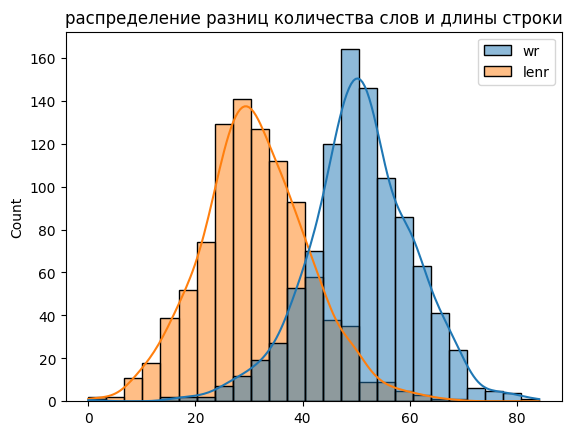

In [ ]:
sns.histplot(df[['wr', 'lenr']], kde=True)
plt.title('распределение разниц количества слов и длины строки')
plt.show()

Полученные данные позволяют нам сделать следующие выводы:


1. Значительное сокращение количества слов и длины строки: примерно половина слов в тексте были стоп-словами и после их удаления длина строки уменьшилась более чем на 30 %.
2. Оба распределения нормальны и смещены друг относительно друга. Медианное wr (50.7 %) значительно больше, чем медианное lenr (30,6 %), что говорит о наличии большого количества коротких стоп-слов, таких как предлоги ("в", "на", "из"), союзы ("а", "и") и пр.
3. Довольно высокая вариативность в уменьшении количества слов и длины строки в разных предложениях,  и практически одинаковое стандартное отклонение 9.9 для wr("количество слов") и 10 для lenr ("длина строки").

Посмотрим как выглядит их совместное распределение:

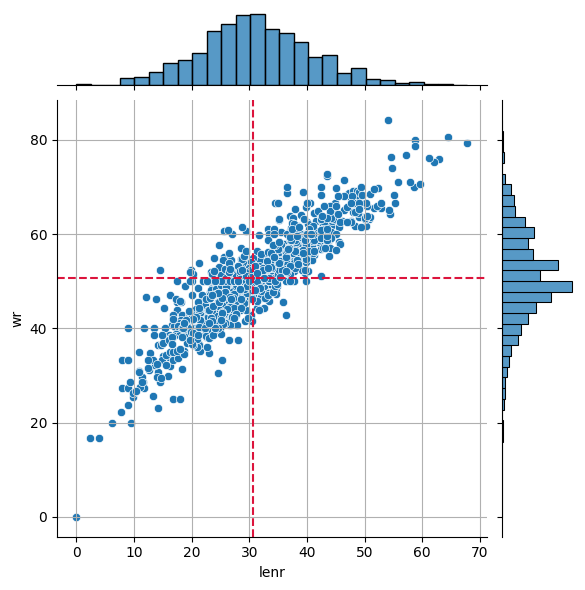

In [ ]:
sns.jointplot(data=df, x='lenr', y='wr')
plt.axvline(x=df.lenr.median(), color='crimson', label='медиана lenr', linestyle='--')
plt.axhline(y=df.wr.median(), color='crimson', label='медиана wr', linestyle='--')
plt.grid()
plt.show()

Ожидаемо, мы имеем линейную зависимость. Из данного графика видно, что у насимеется одна строка, которая изначально не содержала ничего "лишнего". Вот её содержание:

In [ ]:
df[df['lenr']==0].quote

,quote
id,
641,бывают нервные клиенты злятся ругаются


Все ли общераспространённые слова мы удалили, или нам нужно доудалить какие-то слова?  Посмотрим, какими словами изобилует наш текст.

Посмотрим, какими словами изобилует наш текст.

In [ ]:
def word_freq(df):
  plt.figure( figsize=(7,6) )
  wstr=' '.join(df)
  wl=wstr.split(" ")
  wfd=pd.DataFrame(Counter(wl), index=['Qty']).T.sort_values('Qty', ascending=False)
  wordcloud = WordCloud(width=700, height=600, margin=1).generate(wstr)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.margins(x=0, y=0)
  plt.show()
  return wfd

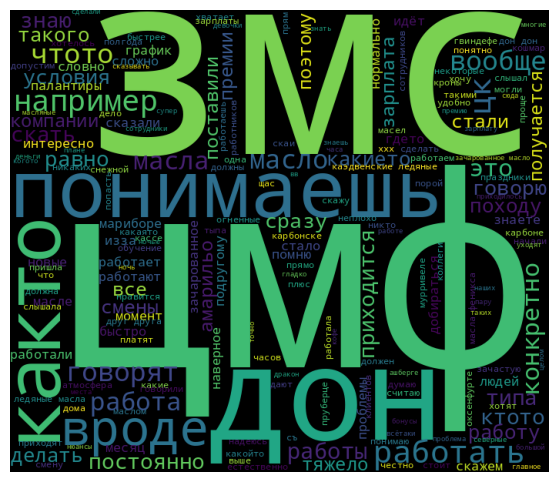

In [ ]:
corpus_wf=word_freq(df.quote)

In [ ]:
corpus_wf.head(20).T

,дон,цмф,змс,понимаешь,както,масла,вроде,работать,цк,например,масло,чтото,говорят,вообще,работа,конкретно,этo,приходится,работы,равно
Qty,195,191,177,140,132,101,99,96,85,82,73,72,65,65,57,52,51,46,43,40


Итак, у нас самым популярным словом является слово дон. Возможно речь идёт о благородных донах, или о региональных офисах на юге Цитрии? Посмотри контексты использования этого слова

In [ ]:
pd.set_option('display.max_colwidth', 130)
display(df.quote[df.quote.str.contains('дон')].head(5))
pd.set_option('display.max_colwidth', 70)

,quote
id,
58,дон квартальная дон система оценки дон както портит дон алхимики дон конвейерные рабочие дон рецепт дон литр масла дон работа ...
67,дон гвиндефе дон дон места ддля обедов дон скрипториумом дон кошмар дон стоять дон очереди дон чаем дон дон дон искать дон дон...
69,зеленосе открыли первую змс восторге зеркал представляешь видеть каждую маслостанцию каждую деталь ладони конкуренты аретусы з...
99,надеюсь гильдия цмф дон наконечн дойдёт обучать сотрудников работе оружием основам работы зачарованным маслом дон ведьь эсли ч...
133,должен дон ска3ать цмф дон карьерный рост дон както ограничен допустим дон можешь дон стать старшим технологом дон неясно ведь...


Как мы видим, данное слово почти всегда не несёт в себе никакого смысла, являясь скорее всего паразитом или междометием. И тут мы кое что вспоминаем :)

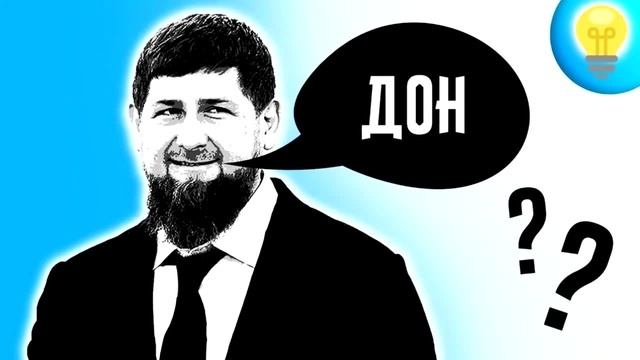



> «Это "дуй хьунан", я для связки слов говорю, как "короче говоря" вот»
>

> Рамзан Кадыров, Глава Чеченской Республики






Как мы видим, эта связка популярна не только в Чечне. Маловероятно, что это слово как-то поможет нам разделить темы, поэтому мы избавляемся от него. Также нам надо разобраться со словами содержащими и не содержащими "змс"/"зсм" и "цмф" (заводы как я понимаю)

Разделим датасет на подгруппы содержащие и не содержащие эти слова, и посмотрим как в них распределены слова

In [ ]:
condition = df['quote'].str.contains('зсм|цмф|змс|дон', case=False)
wo, w=[*df.groupby(condition).quote]

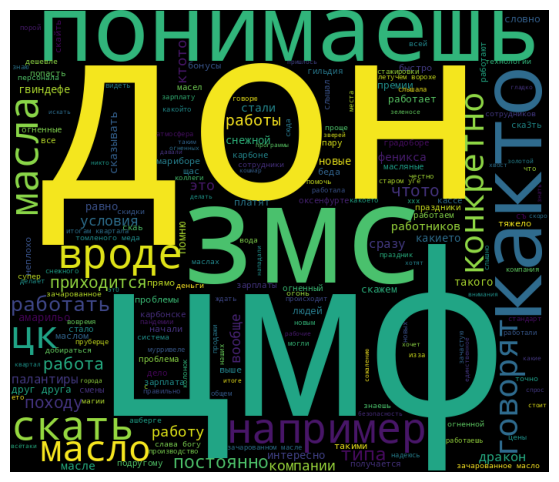

,дон,цмф,змс,понимаешь,както,вроде,например,скать,масло,масла,цк,конкретно,говорят,работать,типа,постоянно,работа,походу,приходится,чтото
Qty,195,191,177,66,56,39,39,38,38,37,36,27,26,26,23,19,18,17,17,17


In [ ]:
word_freq(w[1])[:20].T

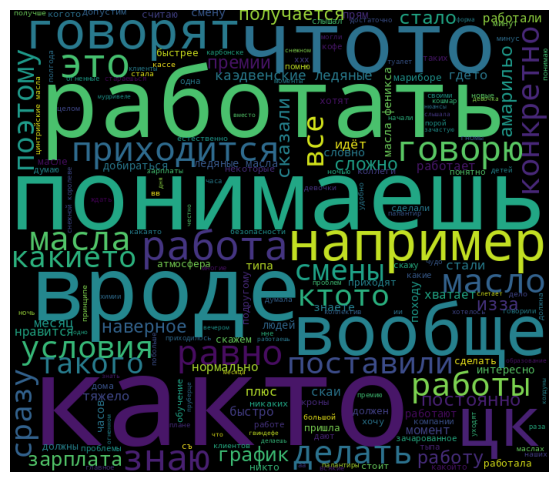

,както,понимаешь,работать,масла,вроде,чтото,вообще,цк,например,работа,говорят,этo,масло,знаю,равно,говорю,приходится,смены,делать,работы
Qty,76,74,70,64,60,55,51,49,43,39,39,37,35,32,30,30,29,29,27,27


In [ ]:
word_freq(wo[1])[:20].T

Мы видим что мешки слов с этими словами и без них не сильно отличаются, дач что их удаление. по всей видимости не причинит вреда. Удаляем эти слова и ранее обсуждавшиеся слова, а также слова паразиты и малозначимые слова который нам встречаются в этих мешках.

In [ ]:
abnd_sw=['дон', 'цмф',	'змс', 'зсм',	'понимаешь',	'както', 'вроде', 'например',
         'скать',	'масло',	'масла', 'цк', 'конкретно', 'говорят', 'както',
         'чтото',	'вообще',	'цк',	'работа',	'этo', 'знаю',	'равно', 'походу', 'ктото']

In [ ]:
sw.update(abnd_sw)

In [ ]:
df.quote=df.quote.apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in sw]))

Посмотрим на очищенный текст

In [ ]:
df.quote.head()

,quote
id,
0,ннас среди ночi райооне 55 часов упала полxа водой сттеклянной тар...
1,программы повышения квалификации гильдию хитрые хитрые хочет повыш...
2,новиград город контрастов превратились котов никто хочет протянуть...
3,типа полгода ждем установки фильтров маслобазе думаю бесконечные о...
4,всьё бумажки летали терялись искать приходилось зеленосу одном мес...


Текст содержит большое количество опечаток и задвоений. Попробуем его очистить.

Были предприняты попытки исправить ошибки с помощью DeepPavlov, но при попытке осуществить это на компьютере, возникли сложности с совместимостью пакетов. На колабе был опробован спеллчеккер на модели 'UrukHan/t5-russian-spell' (https://huggingface.co/UrukHan/t5-russian-spell), но модель работала очень долго (15 минут) и требовала использования GPU.

Поиск альтернативного решения привёл к спел-чеккеру Yandex, который и был использован. При меньших временных затратах (около 9 минут), программа обошлась использованием CPU.

In [ ]:
s_t=time.time()
df_quote_schke=df.quote.apply(spellcheck)
e_t=time.time()
delta=e_t-s_t

In [ ]:

print(delta/60)

10.712583100795745


In [ ]:
pd.DataFrame([df_quote_schke, df.quote]).T

,quote,quote
id,,
0,нас среди ночи районе 55 часов упала полка водой стеклянной таре т...,ннас среди ночi райооне 55 часов упала полxа водой сттеклянной тар...
1,программы повышения квалификации гильдию хитрые хитрые хочет повыш...,программы повышения квалификации гильдию хитрые хитрые хочет повыш...
2,новиград город контрастов превратились котов никто хочет протянуть...,новиград город контрастов превратились котов никто хочет протянуть...
3,типа полгода ждем установки фильтров маслобазе думаю бесконечные о...,типа полгода ждем установки фильтров маслобазе думаю бесконечные о...
4,все бумажки летали терялись искать приходилось зеленому одном мест...,всьё бумажки летали терялись искать приходилось зеленосу одном мес...
...,...,...
954,в го rhode ночных смен по моему 2 22 как то работают нормально пол...,вв го rhode ночных смен помоеммууу 2 22 кккактоо работтают ноормма...
955,праздники организовано восторге рождения отмечает поздравления раз...,праздники организованно восторге рождения отмечает поздравления ра...
956,женском кооолектииивъ равно склок избежать,жеенском кооолектииивъ раавно скллокк иззбежаттьь


Спел-чеккер отрабатывает достаточно качественно и быстра, затруднения у него возникают при обработке слов с пропусками либо слов имеющих более двух дублирующихся букв. В будущем, желательно провести доочисту корпуса, но сейчас мы ограничимся текущим уронем предобработки. Для контроля, сохраняем корпус в файл формата json

In [ ]:
df_quote_schke.to_json('cintra_phoenix_oils_spellchecked.json')

Сохранив файл двигаемся дальше и подвергаем наш корпус лемматизации

# Лемматизация

Проведём токенизацию с помощью токенайзера NLTK и лемматизацию c помощью пакета pymorhy2

In [ ]:
from nltk.tokenize import word_tokenize


In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
!pip install pymorphy2
from pymorphy2 import MorphAnalyzer

parser = MorphAnalyzer()

def toklem_preproc(series):
    tokenized = word_tokenize(series)
    clean_text = [word for word in tokenized if word not in sw]
    lemmatized = [parser.parse(word)[0].normal_form for word in clean_text]

    return lemmatized

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 33.6 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=84fabe7f8af719781fbb41f2abe51dda220a53f8d968cd716b6640ee8f358730
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
tlp=df_quote_schke.apply(toklem_preproc)

In [ ]:
tlp

,quote
id,
0,"[среди, ночь, район, 55, час, упасть, полка, вода, стеклянный, тар..."
1,"[программа, повышение, квалификация, гильдия, хитрый, хитрый, хоте..."
2,"[новиград, город, контраст, превратиться, кот, никто, хотеть, прот..."
3,"[тип, полгода, ждать, установка, фильтр, маслобаза, думать, бескон..."
4,"[бумажка, летать, теряться, искать, приходиться, зелёный, один, ме..."
...,...
954,"[го, rhode, ночной, смена, мой, 2, 22, работать, нормально, получа..."
955,"[праздник, организовать, восторг, рождение, отмечать, поздравление..."
956,"[женский, кооолектииивъ, склока, избежать]"


In [ ]:
a=" ".join(df.quote).split()
print(a)

['ннас', 'среди', 'ночi', 'райооне', '55', 'часов', 'упала', 'полxа', 'водой', 'сттеклянной', 'таре', 'тоесть', 'лужа', 'сстеккла', 'всёё', 'поод', 'утро', 'ээто', 'перрвыи', 'падают', 'неправилььно', 'рассчитывают', 'должны', 'выставлять', 'определённой', 'картинке', 'пару', 'чтоо', 'грохаются', 'полки', 'буттылками', 'программы', 'повышения', 'квалификации', 'гильдию', 'хитрые', 'хитрые', 'хочет', 'повышаться', 'предпочтения', 'направления', 'гильдия', 'гильдия', 'толкает', 'сотрудникам', 'белых', 'змеях', 'программы', 'гибче', 'сотрудники', 'выбирают', 'новиград', 'город', 'контрастов', 'превратились', 'котов', 'никто', 'хочет', 'протянуть', 'лапку', 'товарищу', 'помочь', 'грузом', 'напряжении', 'спешке', 'работали', 'втроем', 'порознь', 'типа', 'полгода', 'ждем', 'установки', 'фильтров', 'маслобазе', 'думаю', 'бесконечные', 'огненные', 'огни', 'затягивали', 'поставками', 'порядке', 'всьё', 'бумажки', 'летали', 'терялись', 'искать', 'приходилось', 'зеленосу', 'одном', 'месте', 'план

Для тематического моделирования, мы будем использовать пакет Gensim. Создадим в нём словарь, отфильтровав из него слова с долей встречаемости в текстах более 0.1 и количеством документов в которых они встречаются, не менее 3. После этого создаём корпус и передаём его для в функцию сознания модели латентного размещения Дирихле

In [ ]:
import gensim

gensim_dictionary = gensim.corpora.Dictionary(tlp)
gensim_dictionary.filter_extremes(no_above=0.1, no_below=3)
gensim_dictionary.compactify()
corpus = [gensim_dictionary.doc2bow(txt) for txt in tlp]
lda_10 = gensim.models.LdaMulticore(corpus,
                                 num_topics=10,
                                 id2word=gensim_dictionary,
                                 passes=50, random_state=42)

In [ ]:
lda_10.print_topics()

[(0,
  '0.015*"праздник" + 0.015*"работа" + 0.014*"день" + 0.012*"рождение" + 0.011*"стараться" + 0.010*"амарильо" + 0.010*"львиный" + 0.010*"приходить" + 0.010*"идея" + 0.009*"коллега"'),
 (1,
  '0.021*"новый" + 0.013*"красный" + 0.012*"снежный" + 0.011*"поставить" + 0.011*"приходиться" + 0.010*"стать" + 0.009*"палантир" + 0.009*"дракон" + 0.009*"справляться" + 0.008*"фильтр"'),
 (2,
  '0.019*"говорить" + 0.015*"клиент" + 0.012*"хотеть" + 0.012*"делать" + 0.011*"знать" + 0.010*"должный" + 0.010*"сказать" + 0.010*"работа" + 0.009*"смена" + 0.009*"касса"'),
 (3,
  '0.015*"феникс" + 0.012*"компания" + 0.012*"момент" + 0.011*"смена" + 0.010*"говорить" + 0.010*"идти" + 0.008*"работа" + 0.008*"платить" + 0.008*"месяц" + 0.008*"новый"'),
 (4,
  '0.011*"стать" + 0.011*"место" + 0.010*"никакой" + 0.010*"зачаровать" + 0.010*"гильдия" + 0.009*"снежный" + 0.009*"давать" + 0.009*"оплата" + 0.008*"час" + 0.008*"схема"'),
 (5,
  '0.037*"тип" + 0.013*"приходиться" + 0.012*"старый" + 0.011*"колдун" + 

Мы видим, что тематическое моделирование позволяет нам выделить следующие темы:

0) Ивент-менеджмент

1) Оборудование

2) Сбытовые операции

3) Сравнение условий оплаты труда в компаниях-конкурентах

4) Схема оплаты труда

5) Производственный процесс

6) Маркетинг

7) Возможно круглосуточная торговля

8) Система квартального и годового премирования

9) Отношения в коллективе





In [ ]:
gensim_dictionary = gensim.corpora.Dictionary(tlp)
gensim_dictionary.filter_extremes(no_above=0.1, no_below=3)
gensim_dictionary.compactify()
corpus = [gensim_dictionary.doc2bow(txt) for txt in tlp]
lda_10 = gensim.models.LdaMulticore(corpus,
                                 num_topics=10,
                                 id2word=gensim_dictionary,
                                 passes=100, random_state=42)

text_to_classify_1='Когда новый палантир будет'
new_text_corpus_1 =  id2word.doc2bow(text_to_classify_1.split())
lda_10[new_text_corpus_1]

NameError: name 'id2word' is not defined

In [ ]:
lda_10.show_topics(num_topics=10, num_words=10, formatted=True)

# Обсуждение результатов



1.   Нам удалось выделить 10 тем к которым предположительно относятся документы созданные самопишущим цидарийским пером.
2.  LDA позволяет обновлять корус (update), а также предсказывать класс текста.

